In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

In [5]:
df = pd.read_csv('data/2001_all_materials.csv')

In [8]:
df['zzibrnd'] = df['zzibrnd'].astype(str)
df['TherapeuticClass'] = df['TherapeuticClass'].astype(str)
df['PrincipalName'] = df['PrincipalName'].astype(str)
df['Description'] = df['Description'].astype(str)

In [9]:
# remove special characters (& \n) from category/sub category/type
def splitcategory(x):
    if isinstance(x, list):
        return x
    else:
        if isinstance(x, str):
            res = re.split('& |, |\*|\n', x)
            return res
        else:
            return ''

# function to change characters to lower case
def cleaner(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

# change text to lower case
def changeCase(x):
    return str.lower(x)

# merge all text columns
def couple(x):
    return x['zzibrnd'] + ' ' + ' '.join(x['TherapeuticClass_new']) + ' '.join( x['PrincipalName_new']) + ' ' + x['Description'] 

In [12]:
# remove special characters
df['zzibrnd_new'] = df['zzibrnd'].apply(splitcategory)
df['TherapeuticClass_new'] = df['TherapeuticClass'].apply(splitcategory)
df['PrincipalName_new'] = df['PrincipalName'].apply(splitcategory)


# mix all text columns
df['soup'] = df.apply(couple, axis=1)
df['soup'] = df['soup'].apply(changeCase)

In [15]:
df['soup'][0]

'dermaveen soap free all other non-therapeutic productsinova pharmaceuticals (s) pte dermaveen soap freewash500ml'

In [16]:
def preprocess_text(question):
    question = question.replace("S08_", "")
    question = question.replace("NOTTTT  FOUND", "")
    question = re.sub("([\(\[]).*?([\)\]])", "", question) # remove text between brackets
    question = re.sub("[^\w\s]", "", question) # remove punctuations
    re.sub("\s+", " ", question) # remove multiple white spaces
    re.sub("[\t\n]", "", question) # remove tabs and newline characters
    question = question.lower().strip()
    return question

In [17]:
df['soup'] = df['soup'].apply(preprocess_text)

In [20]:
text = df['soup']
text[0]

'dermaveen soap free all other nontherapeutic productsinova pharmaceuticals  pte dermaveen soap freewash500ml'

In [24]:
def preprocess_length(question):
    return len(question)

In [26]:
df['soup_length'] = df['soup'].apply(preprocess_length)

In [27]:
df['soup_length'] 

0       108
1        87
2        98
3        91
4        98
       ... 
4778    104
4779     96
4780     82
4781     80
4782     99
Name: soup_length, Length: 4783, dtype: int64

In [31]:
df['soup_length'].mean()

91.25883336817897

C:\Users\DELL\.conda\envs\projects\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='soup_length', ylabel='Density'>

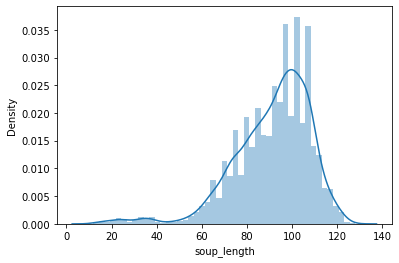

In [29]:
sns.distplot(df['soup_length'])

In [32]:
mean = df['soup_length'].mean()
std = df['soup_length'].std()
print(f"mean: {mean}, std: {std}")

mean: 91.25883336817897, std: 17.120013091156284


In [33]:
optimum_length = int(mean + std)
print(f"optimum length: {optimum_length}")

optimum length: 108


In [35]:
res = df[ df['soup_length'] < 108]

In [37]:
res

,matnr,zzprncode,zzibrnd,mtart,matkl,TherapeuticClass,PrincipalName,mstae,mstde,mstav,...,prat5,prat6,prat7,prat8,prat9,zzibrnd_new,TherapeuticClass_new,PrincipalName_new,soup,soup_length
1,23046633,101234.0,KENHANCER PLASTER,ZF03,ZMC,Topical antirheumatics,SUN PHARMACEUTICAL SDN BHD,LR,20250101,LR,...,NaN,NaN,NaN,NaN,NaN,[KENHANCER PLASTER],[Topical antirheumatics],[SUN PHARMACEUTICAL SDN BHD],kenhancer plaster topical antirheumaticssun ph...,87
2,21210803,101223.0,TECNIS ONE ZCB 06.5D,ZF01,ZMD,Cataract and anticataractogenic preps.,ABBOTT MEDICAL OPTICS,LR,99910101,LR,...,NaN,NaN,NaN,NaN,NaN,[TECNIS ONE ZCB 06.5D],[Cataract and anticataractogenic preps.],[ABBOTT MEDICAL OPTICS],tecnis one zcb 065d cataract and anticataracto...,98
3,23064902,101369.0,REDOXON KIDS DA CHEW,ZF03,ZCH,Vitamin C combinations,BAYER CO (MALAYSIA) SDN BHD,LR,20250101,LR,...,NaN,NaN,NaN,NaN,NaN,[REDOXON KIDS DA CHEW],[Vitamin C combinations],[BAYER CO (MALAYSIA) SDN BHD],redoxon kids da chew vitamin c combinationsbay...,91
4,21037570,101223.0,TECNIS ONE ZCB 21.0D,ZF01,ZMD,Cataract and anticataractogenic preps.,ABBOTT MEDICAL OPTICS,LR,20250101,LR,...,NaN,NaN,NaN,NaN,NaN,[TECNIS ONE ZCB 21.0D],[Cataract and anticataractogenic preps.],[ABBOTT MEDICAL OPTICS],tecnis one zcb 210d cataract and anticataracto...,98
5,23344235,102575.0,SynMesh Cutter,ZF03,ZPE,Promotional items,STRYKER CORPORATION (M) SDN BHD,LR,99901231,LR,...,NaN,NaN,NaN,NaN,NaN,[SynMesh Cutter],[Promotional items],[STRYKER CORPORATION (M) SDN BHD],synmesh cutter promotional itemsstryker corpor...,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,23064645,101369.0,BEPANTHEN FIRST AID,ZF03,ZWM,All other wound healing agents,BAYER CO (MALAYSIA) SDN BHD,LR,20250101,LR,...,NaN,NaN,NaN,NaN,NaN,[BEPANTHEN FIRST AID],[All other wound healing agents],[BAYER CO (MALAYSIA) SDN BHD],bepanthen first aid all other wound healing ag...,104
4779,23348769,101228.0,(Z) JANUMET XR 50/,ZF03,ZPE,DPP-IV Inhibitor & Biguanide Antidiab.,MERCK SHARP & DOHME (I.A),LR,20241206,LR,...,NaN,NaN,NaN,NaN,NaN,[(Z) JANUMET XR 50/],"[DPP-IV Inhibitor , Biguanide Antidiab.]","[MERCK SHARP , DOHME (I.A)]",janumet xr 50 dppiv inhibitor biguanide antid...,96
4780,23348901,101219.0,(Z) MABTHERA VIAL,ZF03,ZPE,Other Immunosuppressants,ROCHE (MALAYSIA) SDN BHD,LR,20250201,LR,...,NaN,NaN,NaN,NaN,NaN,[(Z) MABTHERA VIAL],[Other Immunosuppressants],[ROCHE (MALAYSIA) SDN BHD],mabthera vial other immunosuppressantsroche s...,82
4781,23348920,101219.0,(Z) ACTEMRA VIAL,ZF03,ZPE,Other Immunosuppressants,ROCHE (MALAYSIA) SDN BHD,LR,22241121,LR,...,NaN,NaN,NaN,NaN,NaN,[(Z) ACTEMRA VIAL],[Other Immunosuppressants],[ROCHE (MALAYSIA) SDN BHD],actemra vial other immunosuppressantsroche sd...,80


In [44]:
class QuestionsDataset(Dataset):
    def __init__(self, questions, vocab, sos_token, eos_token, batch_first=False):
        
        # initialize parameters
        self.sos_idx = 0
        self.eos_idx = 1
        self.int2char = {self.sos_idx: sos_token, self.eos_idx: eos_token} # insert start of sentence and end of sentence tokens
        self.int2char.update({idx: char for idx, char in enumerate(vocab, start=self.eos_idx+1)})
        self.char2int = {char: idx for idx, char in self.int2char.items()}
        self.n_chars = len(self.int2char)
        
        # encode and pad questions
        self.questions_encoded = pad_sequence([self.encode_question(q) for q in questions], \
                                              batch_first=batch_first)
                
    def __len__(self):
        return len(self.questions_encoded)
    
    def __getitem__(self, idx):
        return self.questions_encoded[idx]
        
    def encode_question(self, question):
        '''
        encode question as char indices and perform one-hot encoding
        '''
        question_encoded = [self.sos_idx] # append sos
        for char in question:
            question_encoded.append(self.char2int[char])
        question_encoded.append(self.eos_idx) # append eos
        return F.one_hot(torch.tensor(question_encoded, dtype=torch.long), self.n_chars).float()